<span style="font-family: Arial; font-size:1.6em;color:lightblue;"><b> Proyecto Integrador </b><br>
Comisión 1120-ed-13<br>Notebook 3</p>

--------------------

## Grupo 1 - Integrantes

* Oviedo, Cecilia
* Sosa, Gonzalo
* Suchecki, Rocío


--------------------

<a id="section_toc"></a> 

## Tabla de Contenidos

### [1- Imports](#section_imports)  

### [2- Base de datos](#section_dataset)
  - [Carga del dataset](#section_carga)

### [3- Modelo Elegido: Interpretación](#section_conclusion)
  - [Feature importance](#section_feature)
  - [R² por producto](#section_R2)

### [4- Comparativa con Metodología Actual](#section_actual)
### [5- Conclusion General](#section_conclusion)

<a id="section_imports"></a> 
# 1- Imports

[volver a TOC](#section_toc)

In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet, LassoCV, RidgeCV
from sklearn.metrics import r2_score
from sklearn import linear_model
import xgboost as xgb
from sklearn.svm import SVR
import itertools 
import warnings

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

palette='cubehelix'
cmap='cubehelix'

<a id="section_dataset"></a> 
# 2- Base de datos

[volver a TOC](#section_toc)

<a id="section_carga"></a> 
## **Carga del dataset**
[volver a TOC](#section_toc)

In [23]:
#Cargamos el dataset generado tras el análisis previo y la eliminación de outliers
df_clean=pd.read_csv('Base_TP_clean.csv',sep=";",encoding='utf-8')

<div class="alert alert-block alert-info"> <b>ACLARACIÓN</b><br>A continuación copiamos la sección de modelado de los datos, que se encuentra en la segunda notebook, por lo que no se volverá a hacer las aclaraciones de cada paso de dicho procedimiento.</li></div>


In [24]:
df_clean['Cost_USD_Blue']=df_clean.Cost/df_clean.FX_Loss_Date_prev_Blue
df_clean['Product_Purchase_Price_USD_Blue']=df_clean.Product_Purchase_Price/df_clean.FX_Sales_Date_Blue

In [25]:
y = df_clean[['Cost','Cost_USD','Cost_USD_Blue']]
X = df_clean.drop(['Cost','Cost_USD','Cost_USD_Blue'], axis=1)
mask_repair=df_clean.Solution=='Repair'
mask_replace=df_clean.Solution!='Repair'

In [26]:
numericas = [i for i in X.columns if X[i].dtypes != 'object' ]
categoricas = [i for i in X.columns if X[i].dtypes == 'object' ]
categoricas.remove('Product_Group_Solution') #Esta fue creada para el análisis exploratorio pero no es más que una combinación del resto de las features.

In [27]:
numericas_ARS_oficial = ['FX_Sales_Date','FX_Loss_Date_prev','Months_at_loss','Product_Purchase_Price']
numericas_ARS_blue = ['FX_Sales_Date_Blue','FX_Loss_Date_prev_Blue','Months_at_loss','Product_Purchase_Price']
numericas_USD_oficial = ['Months_at_loss','Product_Purchase_Price_USD','FX_Loss_Date_prev']
numericas_USD_blue = ['Months_at_loss','Product_Purchase_Price_USD_Blue','FX_Loss_Date_prev_Blue']

# Dejaremos también separadas las categóricas
categoricas_sin_product_code = categoricas.copy()
categoricas_sin_product_code.remove('Product_Code')

#Para los reemplazos no es necesaria la feature "Service Center" ya que es exclusiva de las reparaciones
categoricas_replace=categoricas.copy()
categoricas_replace.remove('Solution')
categoricas_replace.remove('Service_Center')

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify=X.Solution)
X_train_repair, X_test_repair, y_train_repair, y_test_repair = train_test_split(X[mask_repair], y[mask_repair], test_size=0.3, random_state=42)
X_train_replace, X_test_replace, y_train_replace, y_test_replace = train_test_split(X[mask_replace], y[mask_replace], test_size=0.3, random_state=42)

In [29]:
# Clase para seleccionar columnas
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    
    def transform(self, X, *_):
        if isinstance(X, pd.DataFrame):
            return pd.DataFrame(X[self.columns])
        else:
            raise TypeError("Este Transformador solo funciona en DF de Pandas")
    
    def fit(self, X, *_):
        return self

In [30]:
def modelado(full_pipe,param_grid,X_train,X_test,y_train,y_test):
    grid = GridSearchCV(full_pipe, param_grid, scoring='r2',n_jobs=-1, verbose=10)
    grid.fit(X_train, y_train)
    y_pred = grid.best_estimator_.predict(X_test)
    y_train_pred=grid.best_estimator_.predict(X_train)
    
    #Print de los scores para modelo general:
    print(f'\nLos mejores parametros son: {grid.best_params_}')
    print(f'\nR2 en train: {r2_score(y_train,y_train_pred)}')
    print(f'R2 en test: {r2_score(y_test,y_pred)}')
    r2_repair_test = 0
    r2_replace_test = 0
    #Print de los scores para modelos de reparaciones
    if len(X_train.Solution.unique())==2:
        try:
            mask_repair=X_train.Solution=='Repair'
            r2_repair_train = r2_score(y_train[mask_repair],y_train_pred[mask_repair])
            print(f'\nR2 en train reparaciones: {r2_repair_train}')
            mask_repair=X_test.Solution=='Repair'
            r2_repair_test = r2_score(y_test[mask_repair],y_pred[mask_repair])
            print(f'R2 en test reparaciones: {r2_repair_test}')
            print(y_test[mask_repair].shape)
            print(y_pred[mask_repair].shape)
        except : 
            pass
        
    #Print de los scores para modelos de reemplazos en Train
        try: 
            mask_replacement=X_train.Solution!='Repair'
            r2_replace_train = r2_score(y_train[mask_replacement],y_train_pred[mask_replacement])
            print(f'\nR2 en train reemplazos: {r2_replace_train}')
            mask_replacement=X_test.Solution!='Repair'
            r2_replace_test = r2_score(y_test[mask_replacement],y_pred[mask_replacement])
            print(f'R2 en test reemplazos: {r2_replace_test}')
            print(y_test[mask_replacement].shape)
            print(y_pred[mask_replacement].shape)
        except :
            pass  
    else:
        pass
    if r2_repair_test and r2_replace_test != 0:
        return y_train_pred,y_pred,r2_repair_test,r2_replace_test
    else:
        return y_train_pred,y_pred

In [31]:
#Pipeline para categóricas y numéricas
pipe_num = Pipeline([("select_num", ColumnSelector(numericas)),("scale", StandardScaler())])
pipe_cat = Pipeline([("select_cat", ColumnSelector(categoricas)),("ohe", OneHotEncoder(handle_unknown='ignore'))])
union = FeatureUnion([("numericas", pipe_num),("categoricas", pipe_cat)])
full_pipe = Pipeline([("preprocessing", union),("rgr", None)])

<a id="(section_conclusion)"></a> 
# 3 - Modelo Elegido: Interpretación
[volver a TOC](#section_toc)

Vamos a instanciar el modelo elegido por fuera de las funciones para poder acceder a los diferentes atributos disponibles.

In [32]:
#Replicamos el param grid con los best_parameters y combinacion de variables
param_grid_XG = [{"preprocessing__numericas__select_num__columns":[numericas_USD_blue],
                      "preprocessing__categoricas__select_cat__columns":[categoricas],
        "rgr": [xgb.XGBRegressor()],
        #'rgr__min_child_weight': [1, 5, 10],
        #'rgr__gamma': [0.5, 1, 1.5, 2, 5],
        #'rgr__subsample': [0.6, 0.8, 1.0],
        #'rgr__colsample_bytree': [0.6, 0.8, 1.0],
        #'rgr__max_depth': [3, 4, 5]
        }]

#Fiteamos
grid_best = GridSearchCV(full_pipe, param_grid_XG, scoring='r2',n_jobs=-1, verbose=10)
grid_best.fit(X_train, y_train.Cost)

#Predicciones
y_pred_best = grid_best.best_estimator_.predict(X_test)
y_train_pred_best=grid_best.best_estimator_.predict(X_train)
    
#Print de los scores para modelo general:
print(f'\nLos mejores parametros son: {grid_best.best_params_}')
print(f'\nR2 en train: {r2_score(y_train.Cost,y_train_pred_best)}')
print(f'R2 en test: {r2_score(y_test.Cost,y_pred_best)}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.6s remaining:    8.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    5.6s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.2s finished



Los mejores parametros son: {'preprocessing__categoricas__select_cat__columns': ['Dealer', 'Product_Group', 'Product_SubGroup', 'Product_Code', 'Manufacturer', 'Model', 'Solution', 'Service_Center'], 'preprocessing__numericas__select_num__columns': ['Months_at_loss', 'Product_Purchase_Price_USD_Blue', 'FX_Loss_Date_prev_Blue'], 'rgr': XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None)}

R2 en train: 0.8922109617564151
R2 en

Por otro lado vamos a crear un dataframe que almacene la importancia de cada feature. Habrá muchas features debido a la cantidad de dummies que se generan al inculier todos los modelos/servicios técnicos.

<a id="section_feature"></a> 
## **Feature Importance**
[volver a TOC](#section_toc)

A partir de los atributos de XGBoost vamos a evaluar que features/productos vuelven al modelo más relevante.

In [33]:
names_features=[]
names_features= names_features+grid_best.best_estimator_.named_steps['preprocessing'].transformer_list[0][1].named_steps['select_num'].columns
names_features= names_features+list(itertools.chain(*grid_best.best_estimator_.named_steps['preprocessing'].transformer_list[1][1].named_steps['ohe'].categories_))

In [34]:
diccionario_features = {'Names':names_features,
                       'Importance':grid_best.best_estimator_.named_steps['rgr'].feature_importances_}
df_features = pd.DataFrame(diccionario_features)
dict_features = {}
for colum in list(df_clean.columns):
    dict_features[colum] = list(df_clean[colum].unique())
    
def get_col_name(value):    
    for columns in dict_features.keys():
        for features in dict_features[columns]:
            if features == value:
                return columns
    
df_features['Column_name'] = df_features.Names.apply(lambda x: x if str(get_col_name(x)) == 'None' else get_col_name(x))
#df_features['Column_name'] = df_features.Column_name.apply(lambda x: df_features.Names if str(x) == 'None' else x)
#Top ten
df_features.sort_values('Importance',ascending=False).head(10)

,Names,Importance,Column_name
8,White,0.462941,Product_Group
2727,Reimbursement,0.097347,Solution
14,Celulares,0.021332,Product_SubGroup
2996,3790,0.014587,Service_Center
34,Tv / LCD / LED / Smart / 3D,0.010946,Product_SubGroup
3,A,0.010220,Dealer
1018,HEL.SAMSUNG RT32K553,0.009834,Model
2,FX_Loss_Date_prev_Blue,0.008521,FX_Loss_Date_prev_Blue
231,Whirlpool,0.007332,Manufacturer
120,Asus,0.007233,Manufacturer


Vemos que la feature mas relevante es si es o no de linea blanca Lo segundo es si es o no un reemplazo, y lo tercero, si se trata de un celular.
Aparecen también entre los 10 mas relevantes los televisores, las heladeras Samsung, y cosas mas especificas como un reparador especifico que atiende el siniestro, un vendedor especifico, y 2 marcas.

In [35]:
df_features.groupby(by='Column_name').sum().sort_values(by='Importance',ascending=False).reset_index()

,Column_name,Importance
0,Product_Group,0.471697
1,Model,0.176410
2,Solution,0.097347
3,Service_Center,0.097304
4,Product_SubGroup,0.056872
5,Manufacturer,0.042416
6,Product_Code,0.032232
7,Dealer,0.010220
8,FX_Loss_Date_prev_Blue,0.008521
9,Product_Purchase_Price_USD_Blue,0.006424


Vemos que la linea de negocio es la feature mas importante, seguido por el el modelo de equipo siniestrado, y el tipo de solución

<a id="section_R2"></a> 
## **R² por producto**
[volver a TOC](#section_toc)

A continuación vamos a analizar el scoring del modelo elegido en diferente variables para entender aun mas su perfomance.

In [36]:
#Relevancia en el dataset total de cada segmento/solución
df_clean['Product_Group_Solution']=df_clean.Product_Group +'-'+ df_clean.Solution
df_clean.Product_Group_Solution.value_counts(normalize=True)

White-Repair                  0.327334
Brown-Repair                  0.256632
Grey-Repair                   0.203811
Brown-Reimbursement           0.093630
Grey-Reimbursement            0.064872
White-Reimbursement           0.032006
White-Little-Repair           0.012677
White-Little-Reimbursement    0.005830
Others-Repair                 0.002113
Others-Reimbursement          0.001096
Name: Product_Group_Solution, dtype: float64

In [37]:
#Scoring por semento y solución en Test
X_test['Product_Group_Solution']=X_test.Product_Group +'-'+ X_test.Solution
list_products=X_test.Product_Group_Solution.unique()
name=[]
score=[]
for product in list_products:
    mask_producto=X_test.Product_Group_Solution==product
    name.append(product)
    score.append(r2_score(y_test.Cost[mask_producto],y_pred_best[mask_producto]))

df_score_by_product=pd.DataFrame(zip(name,score),columns=['Name','Score'])
df_score_by_product.sort_values(by='Score',ascending=False)

,Name,Score
4,Grey-Reimbursement,0.822262
7,Others-Reimbursement,0.751978
1,Brown-Reimbursement,0.722349
6,White-Reimbursement,0.639271
9,White-Little-Reimbursement,0.535458
3,Brown-Repair,0.458769
2,Grey-Repair,0.348616
0,White-Repair,0.301589
5,White-Little-Repair,-0.032039
8,Others-Repair,-0.101509


In [38]:
#Relevancia en el dataset total para cada producto
df_clean.Product_SubGroup.value_counts(normalize=True)

Lavarropas / Lavasecarropas          0.264144
Tv / LCD / LED / Smart / 3D          0.221848
Celulares                            0.211949
Notebook                             0.069176
Heladeras y Freezers                 0.044448
Tablets                              0.043665
Audio                                0.042100
Aire acondicionado                   0.033219
Pequeños electrodomésticos           0.015220
Consolas                             0.011895
Computación                          0.011308
Lavaplatos                           0.005869
Anafes - Cocinas - Hornos            0.005752
Secarropas                           0.004304
Microondas                           0.003169
Estufas - Estufas Portátiles         0.001956
DVD/Blue ray                         0.001917
Home Theater / Home Cinema           0.001722
Termotanques - Calefones             0.001604
Teléfonos - Contestadores - Faxes    0.001252
Autoestereo                          0.000978
Maquina de coser                  

In [39]:
#Scoring por producto
list_products=X_test.Product_SubGroup.unique()
name=[]
score=[]
for product in list_products:
    mask_producto=X_test.Product_SubGroup==product
    name.append(product)
    score.append(r2_score(y_test.Cost[mask_producto],y_pred_best[mask_producto]))

df_score_by_product=pd.DataFrame(zip(name,score),columns=['Name','Score'])
df_score_by_product.sort_values(by='Score',ascending=False)

,Name,Score
5,Heladeras y Freezers,0.867067
20,Maquina de coser,0.843602
0,Lavarropas / Lavasecarropas,0.820953
8,Aire acondicionado,0.809509
19,Home Theater / Home Cinema,0.808762
2,Tv / LCD / LED / Smart / 3D,0.803552
16,Lavaplatos,0.799994
7,Tablets,0.796982
11,Computación,0.789951
1,Celulares,0.786487


Vemos qe el score es diferente según de que producto se trate, pero que en los productos que tienen mas representatividad en el dataest los scores estan cercanos al 80%.
Entendemos que otros productos pueden tener una muestra muy chica de datos y eso no ayuda al entrenamiento del modelo.

<a id="section_actual"></a> 
# 4- Comparativa con Metodología Actual
[volver a TOC](#section_toc)

Teniendo el dato de como funciona la metodología actual vamos a calcular el score que se obtendría para poder comprar con el modelo obtenido.

Como contexto la metodologia actual es un promedio lineal que se actualiza trimestralmente a partir de la información del trimestre anterior.
Definimos sus caracteristicas como:

- A través de un Promedio lineal
- Sin distinción por tipo de producto
- Actualizado por trimestre
- No captura saltos inflacionarios
- Siempre estará atrasado y reflejando lo que sucedió el trimestre anterior. 


In [40]:
#Cálculo del score del modelo actual (con la base total neta de outliers y solo para los datos de test)
URL = 'https://drive.google.com/file/d/1ab2YSVnRP9qLu8CFz9wTC9Lb8rdnjWOY/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+URL.split('/')[-2]
df_inicial = pd.read_csv(path, sep=";",encoding='utf-8')
df_inicial = df_inicial[df_inicial.Cost<200000]
print(f'R2 metodología actual: {r2_score(df_inicial.Cost,df_inicial.Reserva)}')

R2 metodología actual: 0.04404741327237238


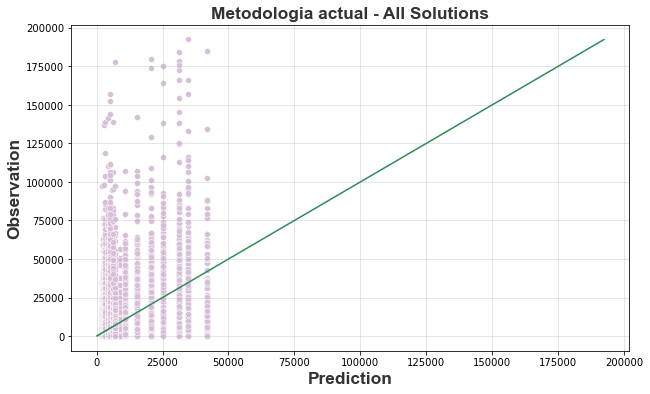

In [41]:
fig, ax = plt.subplots(figsize=(10, 6))
with sns.axes_style('darkgrid'):
    g = sns.scatterplot(x=df_inicial.Reserva,y=df_inicial.Cost,ax=ax,color='Thistle')
    g = sns.lineplot(x = df_inicial.Cost , y= df_inicial.Cost, color="SeaGreen")
    g.set_xlabel('Prediction',weight='bold',size='xx-large',alpha=0.8,family= 'Arial',stretch='extra-expanded')
    g.set_ylabel('Observation',weight='bold',size='xx-large',alpha=0.8,family= 'Arial',stretch='extra-expanded')
    g.set_title('Metodologia actual - All Solutions',weight='bold',size='xx-large',alpha=0.8,family= 'Arial',stretch='extra-expanded') 
    g.grid(alpha=0.4)

Observamos que la metodología actual tiene saltos en los que se incrementa el monto de reserva pero no logra capturar la realidad del comportamiento del costo.
El score obtenido es insignificante dado que ni si quiera divide las soluciones reparación/reemplazo.

<a id="section_conclusion"></a> 
# 5 - Conclusión general
[volver a TOC](#section_toc)

Concluimos que un modelo basado en machine learning permite obtener significativas diferencias para la compañía en la estimación de sus reservas.
Sugerimos tener un único modelo por el momento para reparaciones/reemplazos dado que la diferencia en separarlos no es significativa.
Vemos posibilidades de mejora en el diseño de un modelo de reparaciones a partir de nuevas features que la empresa puedea proveer, pero que exceden los limites, tiempos y permisos de este trabajo práctico.